# Section 0

# Librares

In [3]:
import numpy as np
import pandas as pd
import random
import os
import shutil
import cv2 
import skimage #OTSU
import matplotlib.pyplot as plt
import tarfile

In [4]:
from PIL import Image
from keras import backend as K
import sklearn
import keras
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
from scipy import ndimage as ndi

# Engine

In [6]:
print(tf.__version__)
print(keras.__version__)
!nvidia-smi

2.13.0
2.13.1
Wed Jan 10 14:57:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-----------

In [7]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)

Number of devices: 2


# Metrics

In [8]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def jaccard_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return jaccard

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [9]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    labels = ['NOT tumor', 'NECROTIC/CORE','EDEMA','ENHANCING']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [10]:
def count_flops(layer):
    num_params = layer.count_params()
    layer_type = layer.__class__.__name__

    if "Conv2D" in layer_type:
        # Assuming each convolutional operation requires (2 * kernel_size - 1) FLOPs
        kernel_size = layer.kernel_size[0] * layer.kernel_size[1]
        flops_per_op = (2 * kernel_size - 1) * layer.filters
    elif "Dense" in layer_type:
        # Assuming each dense layer operation requires 2 FLOPs
        flops_per_op = 2
    else:
        # For other layers, a simple assumption
        flops_per_op = 1

    return num_params * flops_per_op


# CallBacks

In [11]:
epochs = 20

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = tf.keras.callbacks.CSVLogger('Model.log')

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)


callbacks = [earlystop, csv_logger, reduce_lr]

# Section 1

# Dataset

In [12]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128


In [13]:
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample

['BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_t1.nii.gz']

In [14]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [15]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_t2.nii.gz',
 'BraTS2021_01261_flair.nii.gz']

In [16]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

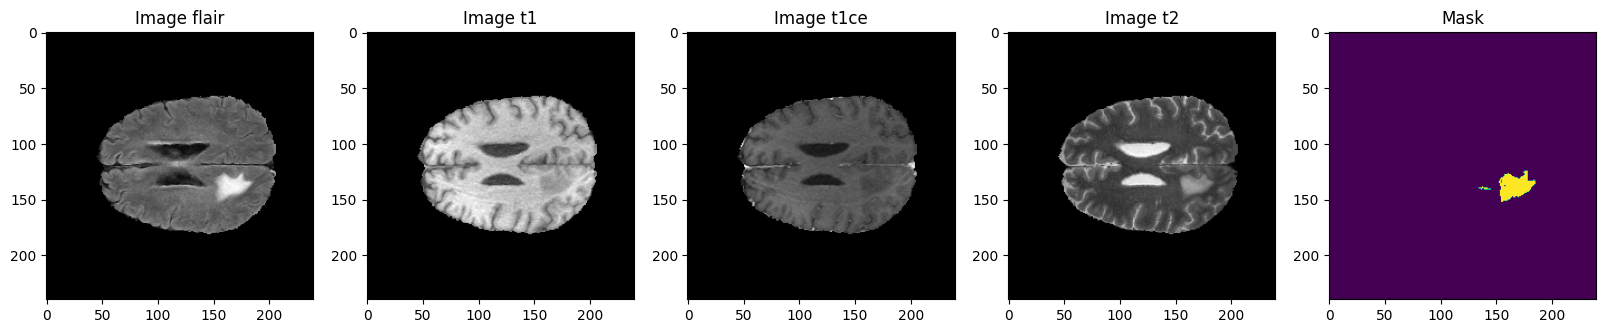

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

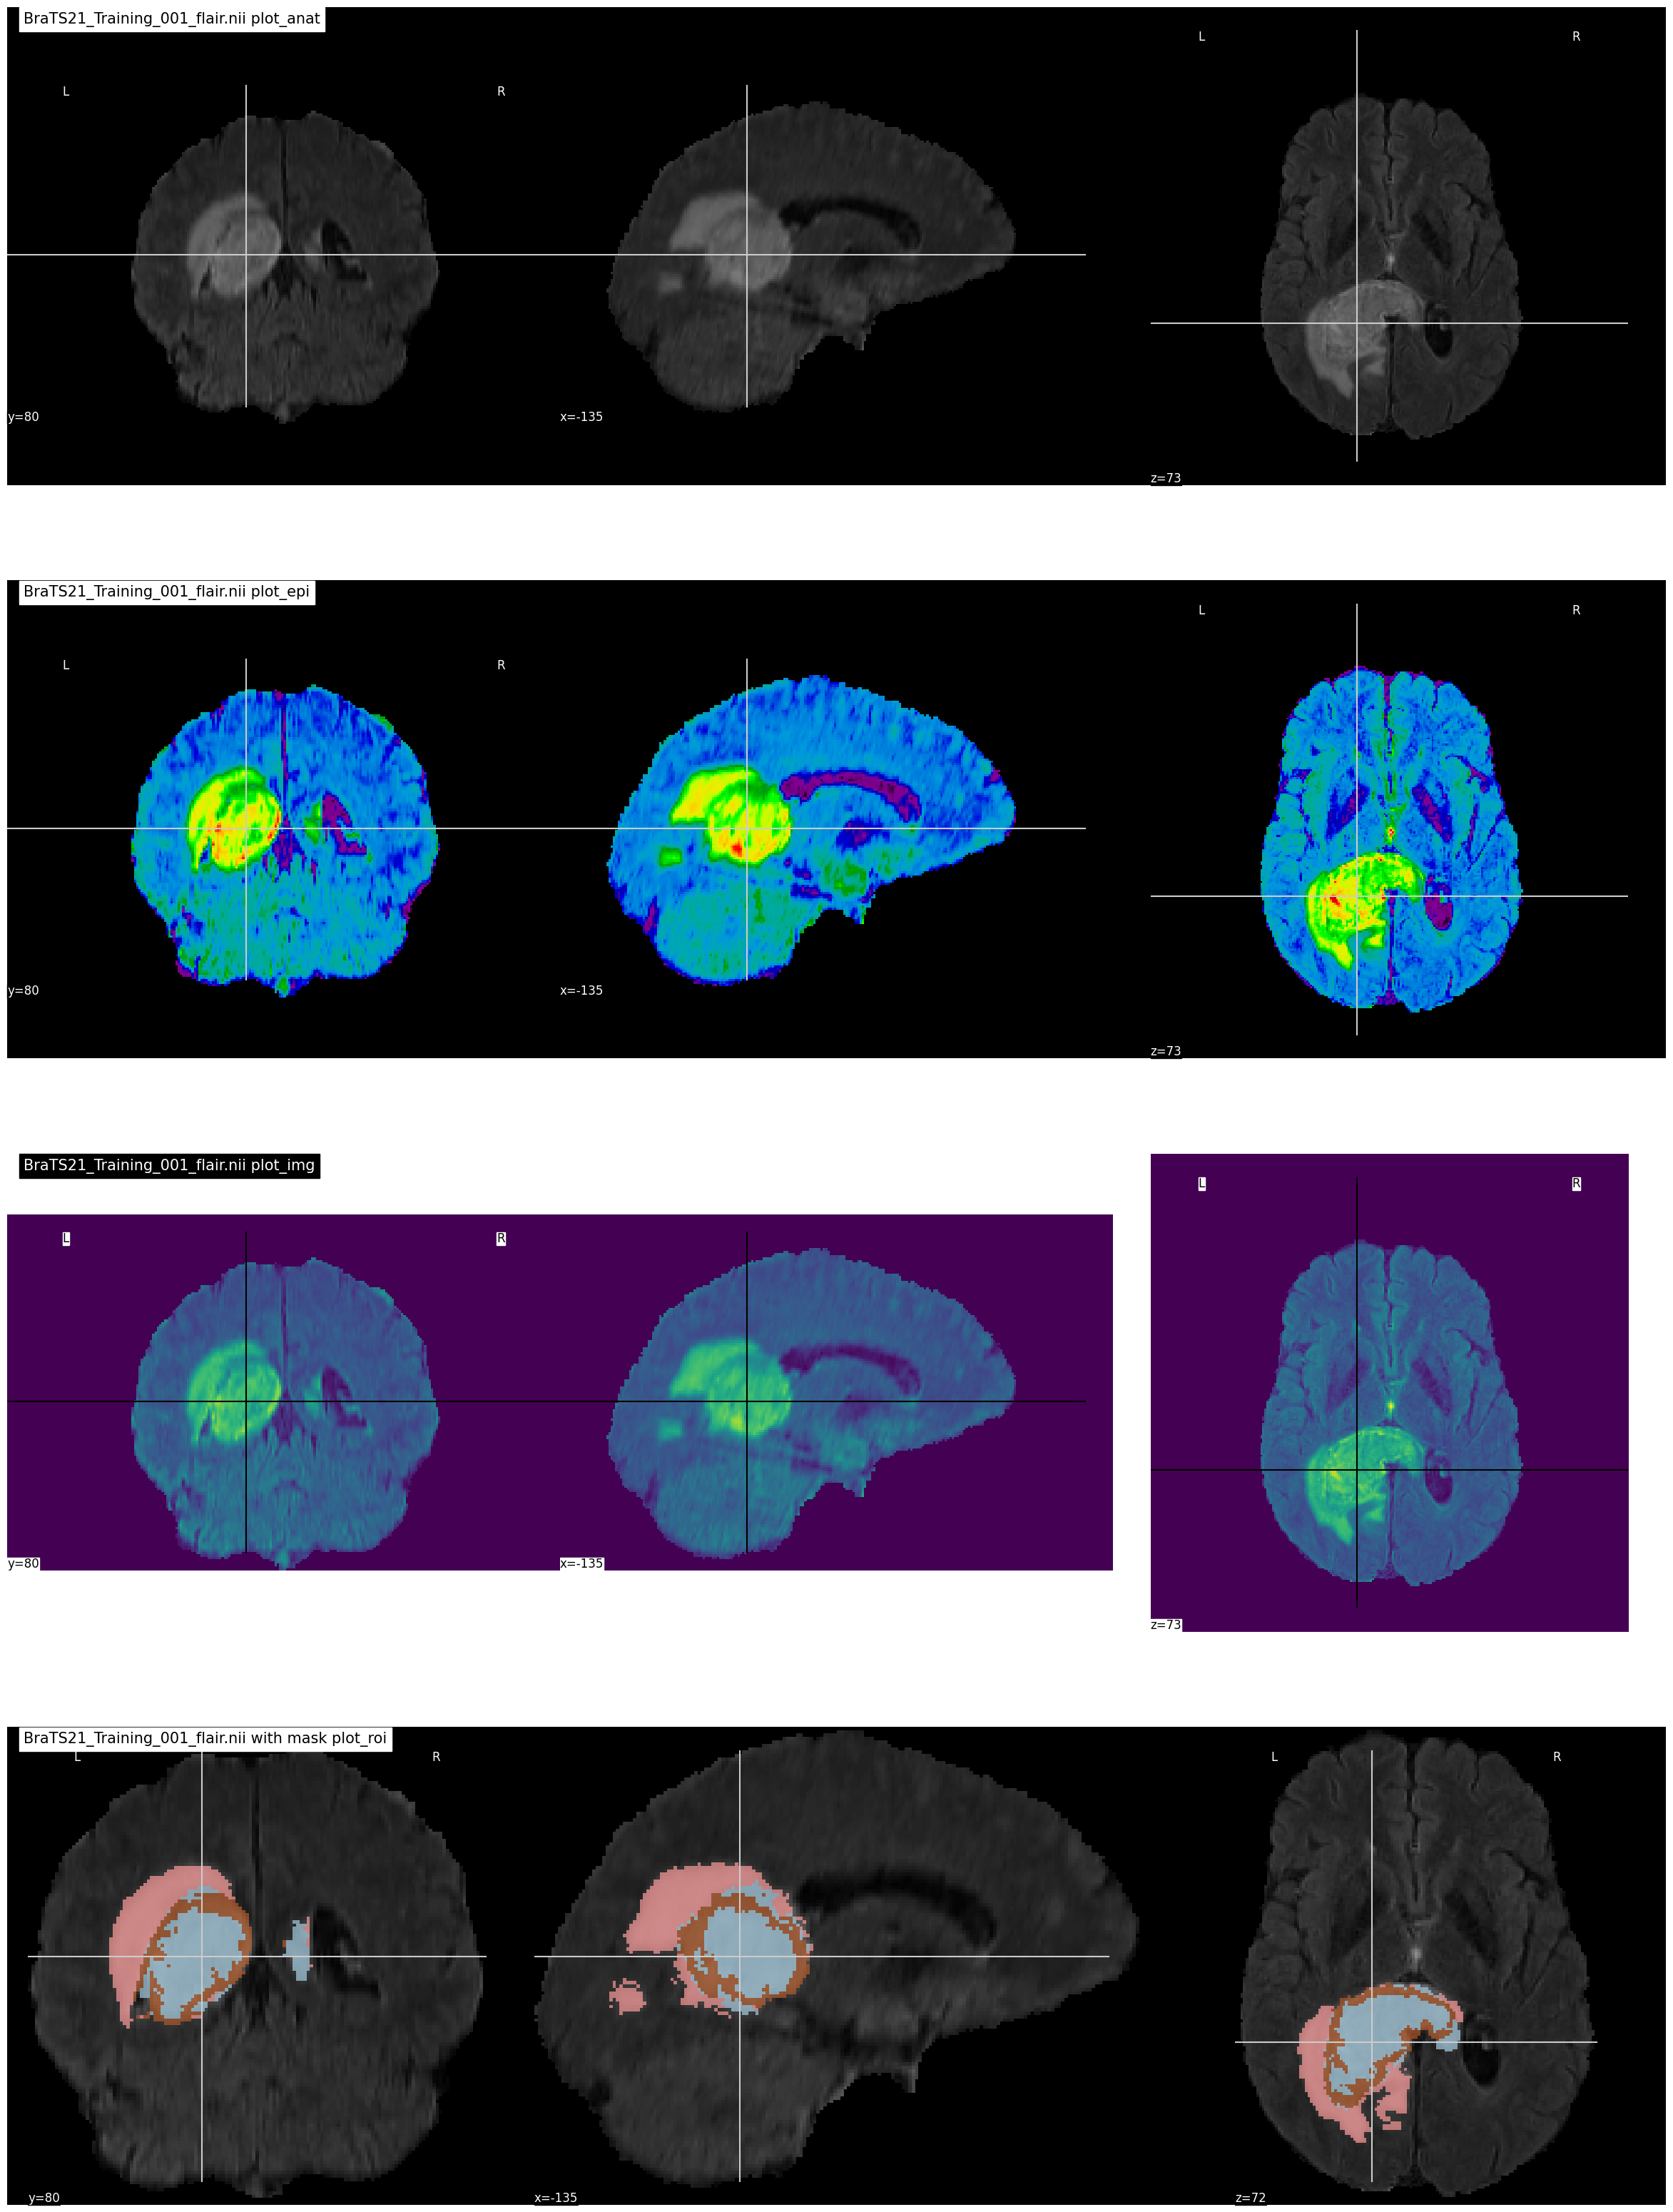

In [18]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS21_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS21_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS21_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS21_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [19]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = sklearn.model_selection.train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = sklearn.model_selection.train_test_split(train_test_ids,test_size=0.15) 

# Section 2

# DataGenerator & Preprocessing

# With tensorflow-Augment And OTSU Thresholding

In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Normalize input data
        X_normalized = (X - np.mean(X)) / np.std(X)
        
        # Convert labels to one-hot encoding
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        mask_resized = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Apply Otsu thresholding to segmentation masks
        otsu_thresholds = np.zeros((self.batch_size * VOLUME_SLICES, 4))
        for i in range(mask_resized.shape[0]):
            for class_idx in range(4):
                otsu_thresholds[i, class_idx] = skimage.filters.threshold_otsu(mask_resized[i, :, :, class_idx].numpy())

        # Reshape otsu_thresholds to match the shape of mask_resized
        otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 1, 1, 4))
        #otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 1, 1, 2, 4))
        #otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 2, 4))
        #otsu_thresholds_reshaped = otsu_thresholds.reshape((self.batch_size * VOLUME_SLICES, 4, 2))
        

        # Binarize masks using Otsu thresholds
        binarized_masks = (mask_resized >= otsu_thresholds_reshaped)
        
        # Apply data augmentation on-the-fly
        augmented_images = []
        augmented_masks = []
        
        for i in range(X_normalized.shape[0]):
            #augmented_images.append(tf.image.random_flip_left_right(X_normalized[i]))
            #augmented_masks.append(tf.image.random_flip_left_right(mask_resized[i]))
            
            
            augmented_images.append(tf.image.random_brightness(X_normalized[i], 0.2))
            augmented_masks.append(tf.image.random_brightness(mask_resized[i], 0.2))
            
            augmented_images.append(tf.image.random_contrast(X_normalized[i], 0.2, 0.5))
            augmented_masks.append(tf.image.random_contrast(mask_resized[i], 0.2, 0.5))

        
        augmented_images = tf.stack(augmented_images)
        augmented_masks = tf.stack(augmented_masks)

        return augmented_images, augmented_masks

# Create instances of the DataGenerator class
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

850
251
150


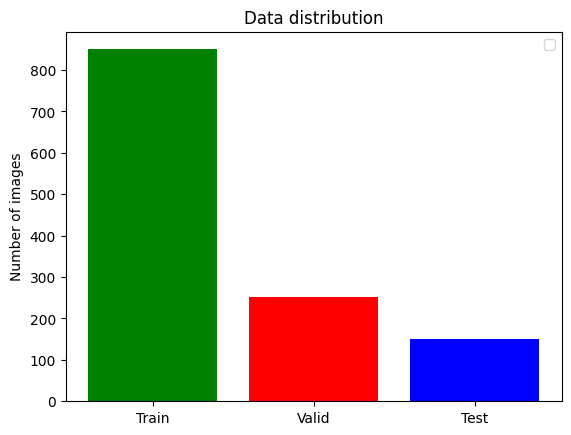

In [21]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
showDataLayout()

# Section 3

# Model

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [23]:
def conv_block(x, filters, kernel_size=(3, 3), activation='elu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x

def ELUnet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = conv_block(pool3, 256)

    # Decoder
    up3 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = conv_block(up3, 128)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = conv_block(up2, 64)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = conv_block(up1, 32)

    outputs = Conv2D(4, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [24]:
%%time
input_shape = (IMG_SIZE, IMG_SIZE, 2)  # Adjust the number of channels according to the data

with strategy.scope():
    model = ELUnet(input_shape)
    model.compile(loss = "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule, 
                                           beta_1 = 0.9, 
                                           beta_2 = 0.999, 
                                           epsilon = 1e-07, 
                                           clipnorm = 0.5,
                                           clipvalue=0.5,
                                           global_clipnorm=None,
                                           weight_decay=1e-5), 
              
            metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC'),
                        f1_score, specificity, sensitivity, iou, dice_coefficient, jaccard_coefficient]))

print(model.input_shape)
print(model.output_shape)
model.summary()
total_flops = sum(count_flops(layer) for layer in model.layers)
print(f"Estimated FLOPs: {total_flops / 1e9} G")

(None, 128, 128, 2)
(None, 128, 128, 4)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         608       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                   

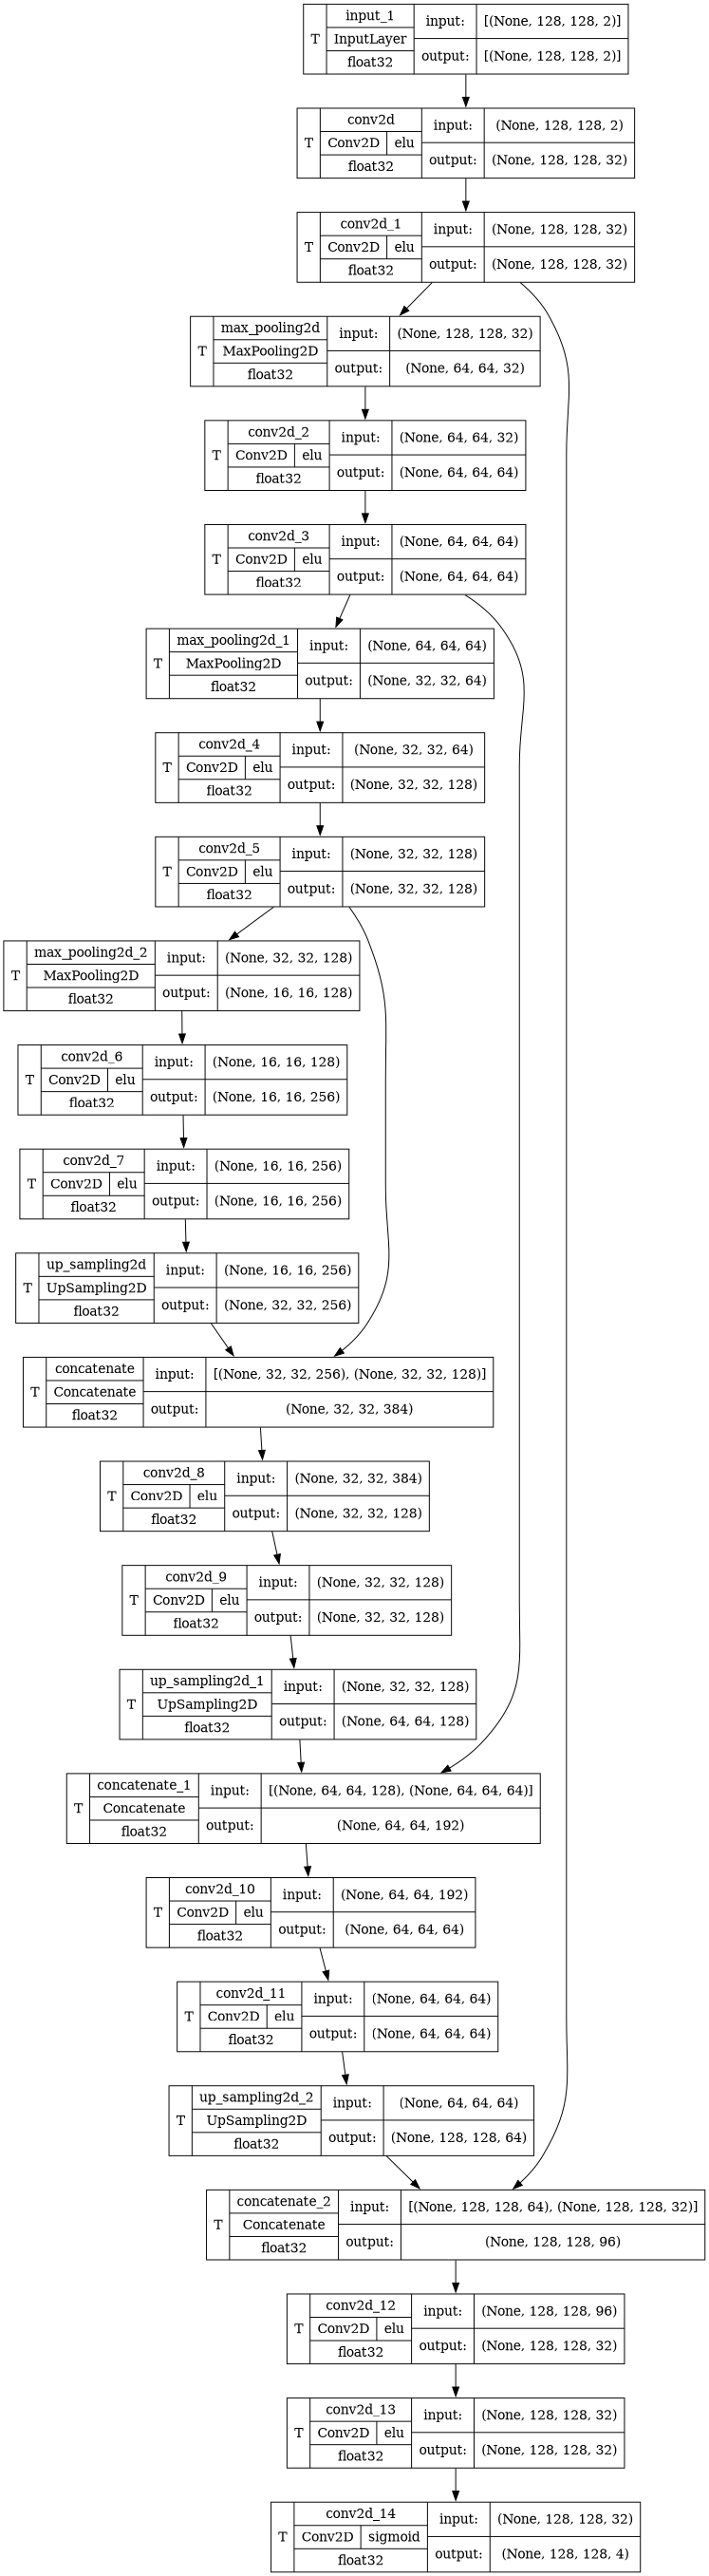

In [25]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
           show_trainable= True,
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Train 

In [26]:
%%time
BATCH_SIZE = 16
history =  model.fit(training_generator,
                        epochs = 20,
                        steps_per_epoch=len(train_ids)//BATCH_SIZE,
                        validation_data = valid_generator,
                        validation_steps=len(val_ids)//BATCH_SIZE,
                        callbacks = callbacks) 

Epoch 1/20
53/53 [==============================] - 130s 2s/step - loss: 0.1742 - accuracy: 0.9653 - precision: 0.9449 - recall: 0.3751 - AUC: 0.6703 - f1_score: 0.8706 - specificity: 0.8957 - sensitivity: 0.9564 - iou: 0.6493 - dice_coefficient: 0.7722 - jaccard_coefficient: 0.7202 - val_loss: 0.1004 - val_accuracy: 0.9909 - val_precision: 0.9999 - val_recall: 0.3140 - val_AUC: 0.6971 - val_f1_score: 0.9886 - val_specificity: 0.9947 - val_sensitivity: 0.9914 - val_iou: 0.8834 - val_dice_coefficient: 0.9377 - val_jaccard_coefficient: 0.9472 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 105s 2s/step - loss: 2.4394 - accuracy: 0.9895 - precision: 0.9999 - recall: 0.0462 - AUC: 0.5273 - f1_score: 0.1632 - specificity: 0.9988 - sensitivity: 0.1416 - iou: 0.1269 - dice_coefficient: 0.1606 - jaccard_coefficient: 0.1343 - val_loss: 0.2233 - val_accuracy: 0.9432 - val_precision: 0.9768 - val_recall: 0.3684 - val_AUC: 0.6745 - val_f1_score: 0.9023 - val_specificity: 0.9349 - 

# Section 4

In [27]:
model.save("Model.h5")
print('Model save to Disk')

Model save to Disk


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Result

In [28]:
import pandas as pd
df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(30)

,loss,accuracy,precision,recall,AUC,f1_score,specificity,sensitivity,iou,dice_coefficient,...,val_precision,val_recall,val_AUC,val_f1_score,val_specificity,val_sensitivity,val_iou,val_dice_coefficient,val_jaccard_coefficient,lr
0,0.174175,0.965301,0.944867,0.375145,0.670271,0.870593,0.895701,0.956447,6.492549e-01,7.721591e-01,...,0.999908,0.314023,0.697087,9.886428e-01,0.994713,9.914442e-01,8.833547e-01,9.376650e-01,9.471756e-01,0.001
1,2.439365,0.989472,0.999927,0.046179,0.527287,0.163207,0.998758,0.141615,1.268724e-01,1.606187e-01,...,0.976832,0.368419,0.674495,9.022600e-01,0.934919,9.829463e-01,7.140812e-01,8.324777e-01,8.072476e-01,0.001
2,0.198059,0.965964,0.961206,0.101473,0.594055,0.302054,0.980434,0.281395,2.368362e-01,3.100777e-01,...,0.999877,0.168033,0.654385,6.673374e-01,0.998131,5.101159e-01,4.566680e-01,6.245487e-01,4.908461e-01,0.001
3,0.097954,0.987670,0.975866,0.199550,0.674675,0.642311,0.980630,0.583779,5.429205e-01,6.763730e-01,...,1.000000,0.009569,0.656955,5.454732e-02,0.999724,2.811422e-02,2.126148e-01,3.505772e-01,2.347810e-01,0.001
4,0.087828,0.991007,0.999999,0.187340,0.675493,0.597816,0.996636,0.581547,5.129478e-01,6.157851e-01,...,1.000000,0.318769,0.687965,9.874970e-01,0.997637,9.872543e-01,7.914058e-01,8.832429e-01,8.460461e-01,0.001
5,0.060012,0.992050,1.000000,0.228919,0.695161,0.790171,0.999411,0.714514,5.889532e-01,7.288552e-01,...,1.000000,0.001209,0.654311,9.738645e-03,0.999844,4.888576e-03,5.336605e-02,1.013150e-01,5.896958e-02,0.001
6,0.117525,0.990284,1.000000,0.065888,0.669783,0.229667,0.999434,0.208169,2.779615e-01,3.779236e-01,...,1.000000,0.312409,0.702883,9.826159e-01,0.997699,9.766132e-01,8.506206e-01,9.187235e-01,9.077604e-01,0.001
7,0.065503,0.991718,1.000000,0.289643,0.696958,0.936923,0.998750,0.896707,7.204943e-01,8.312038e-01,...,1.000000,0.251906,0.679281,8.801476e-01,0.999763,7.955527e-01,5.683362e-01,7.240775e-01,6.101158e-01,0.001
8,0.082473,0.991771,1.000000,0.025262,0.663611,0.111673,0.999760,0.077498,2.433858e-01,3.804635e-01,...,1.000000,0.009419,0.661759,5.980352e-02,0.999800,3.079222e-02,3.140879e-01,4.779419e-01,3.458028e-01,0.001
9,0.081695,0.990261,1.000000,0.252101,0.685183,0.839797,0.999173,0.791918,6.485367e-01,7.751958e-01,...,1.000000,0.288594,0.662558,9.453899e-01,0.999205,9.012069e-01,6.175740e-01,7.634025e-01,6.649406e-01,0.001


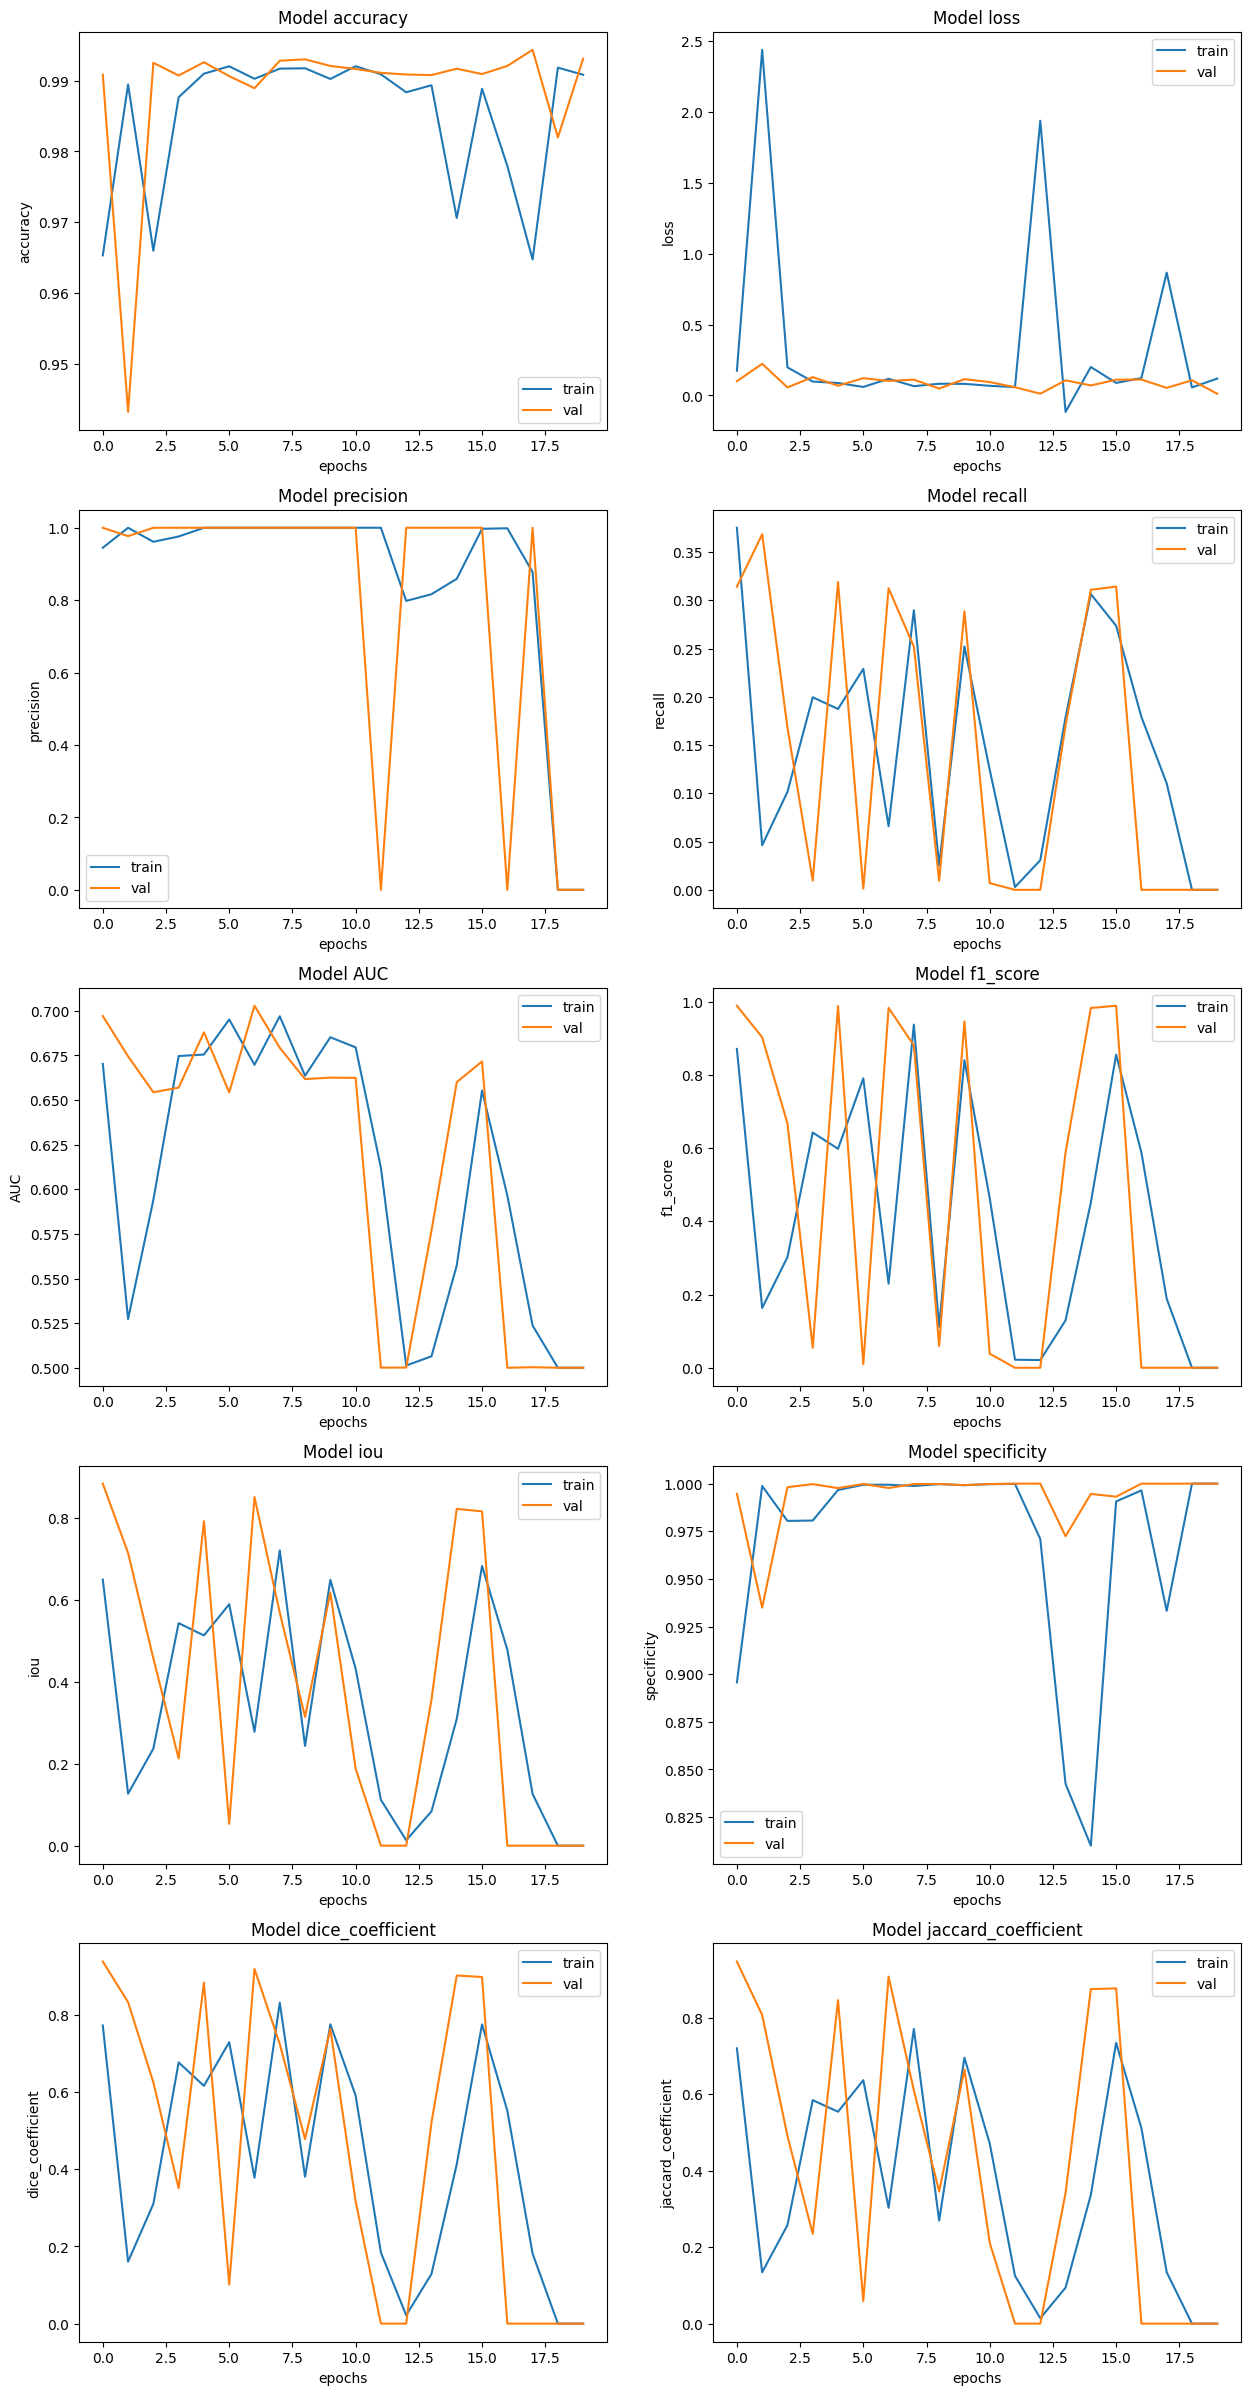

In [29]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC','f1_score', 'iou','specificity','dice_coefficient', 'jaccard_coefficient' ]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

In [30]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size = 16, callbacks = callbacks)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 200s 1s/step - loss: 0.0787 - accuracy: 0.9929 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.5000 - f1_score: 0.0000e+00 - specificity: 1.0000 - sensitivity: 0.0000e+00 - iou: 3.0525e-07 - dice_coefficient: 1.5008e-11 - jaccard_coefficient: 1.1887e-07
test loss, test acc: [0.07870208472013474, 0.9928702116012573, 0.0, 0.0, 0.5, 0.0, 1.0, 0.0, 3.0525225724886695e-07, 1.5008142298378324e-11, 1.188658842465884e-07]
CPU times: user 3min 6s, sys: 35.9 s, total: 3min 42s
Wall time: 3min 20s


4/4 [==============================] - 2s 183ms/step


<Figure size 1800x5000 with 0 Axes>

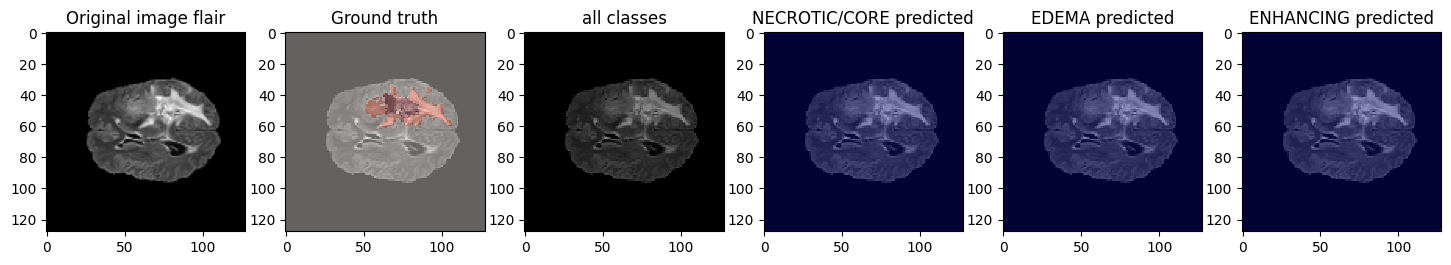

4/4 [==============================] - 0s 30ms/step


<Figure size 1800x5000 with 0 Axes>

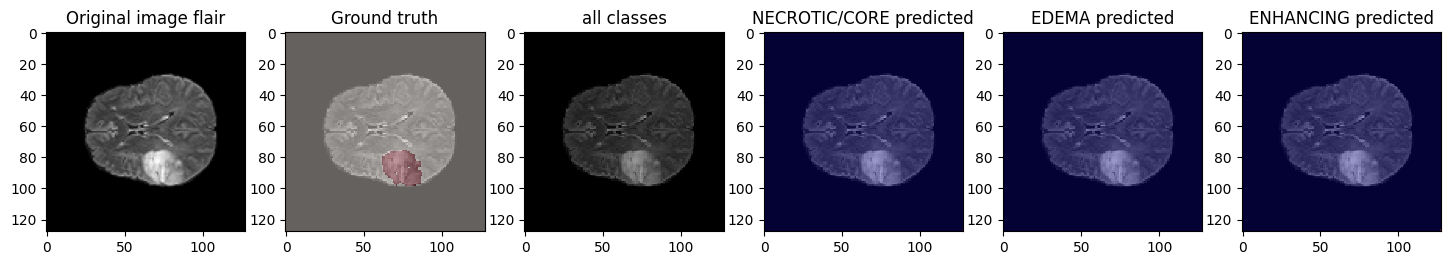

4/4 [==============================] - 0s 30ms/step


<Figure size 1800x5000 with 0 Axes>

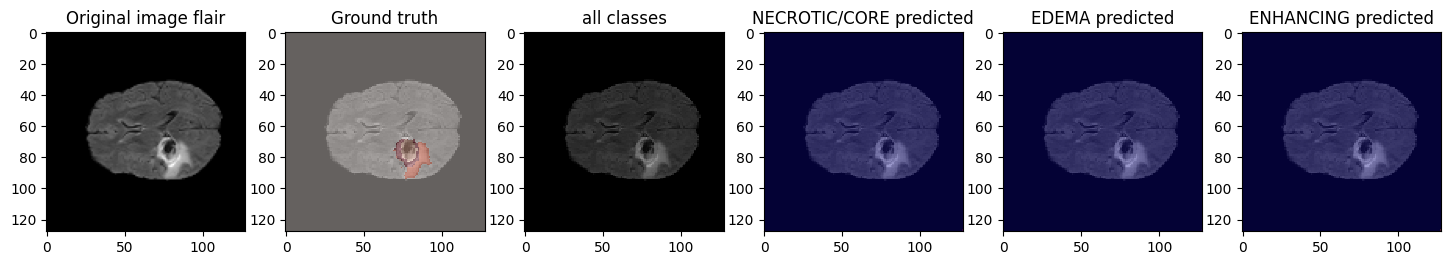

4/4 [==============================] - 0s 32ms/step


<Figure size 1800x5000 with 0 Axes>

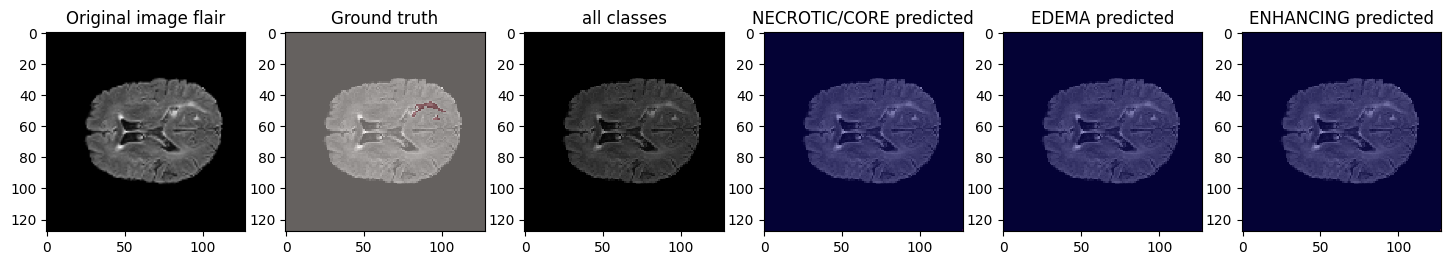

4/4 [==============================] - 0s 47ms/step


<Figure size 1800x5000 with 0 Axes>

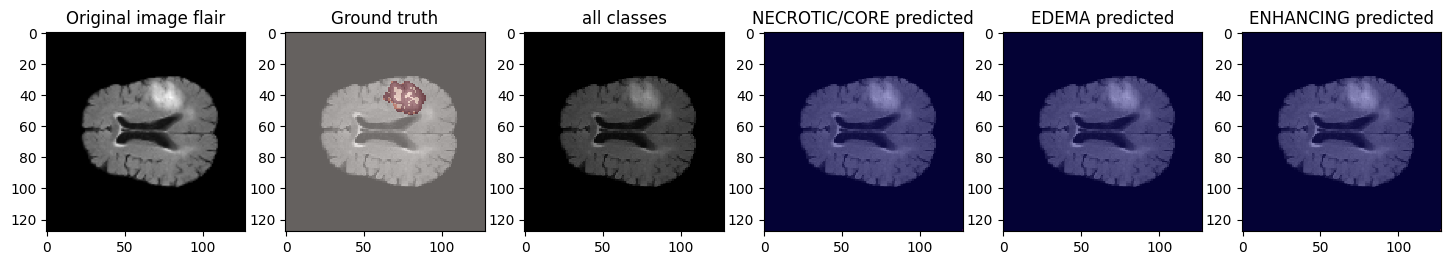

4/4 [==============================] - 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

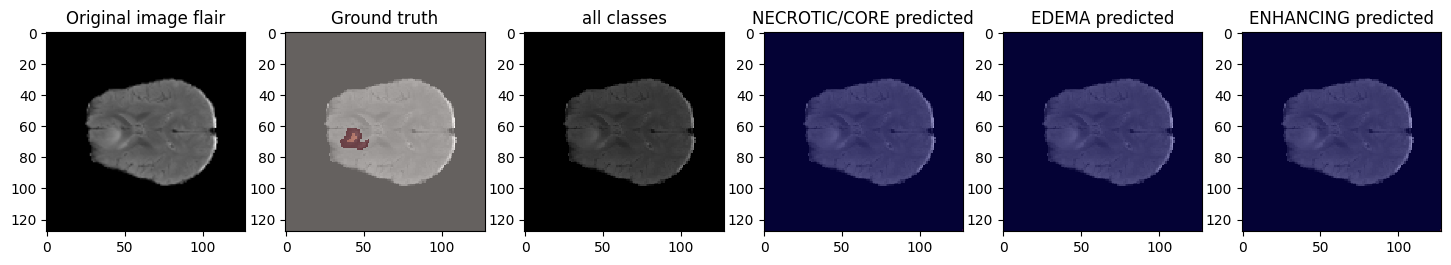

4/4 [==============================] - 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

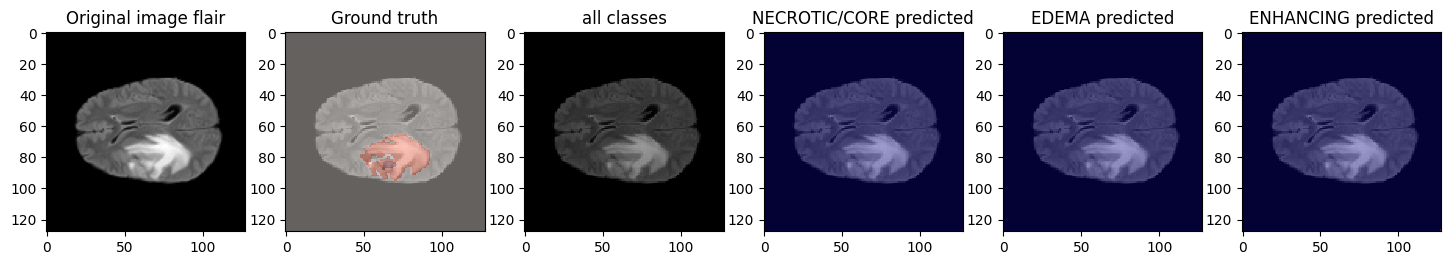

4/4 [==============================] - 0s 42ms/step


<Figure size 1800x5000 with 0 Axes>

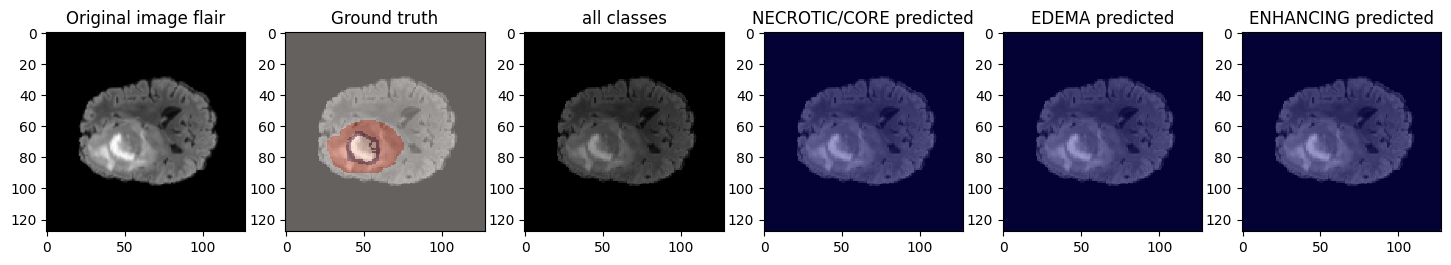

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

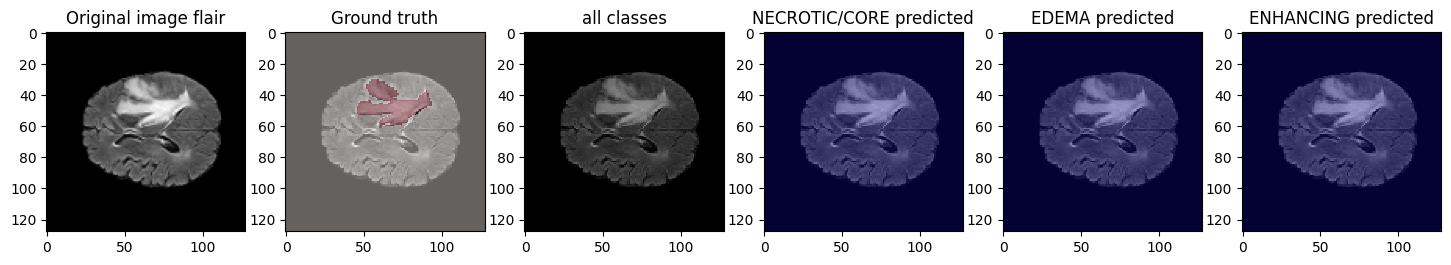

4/4 [==============================] - 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

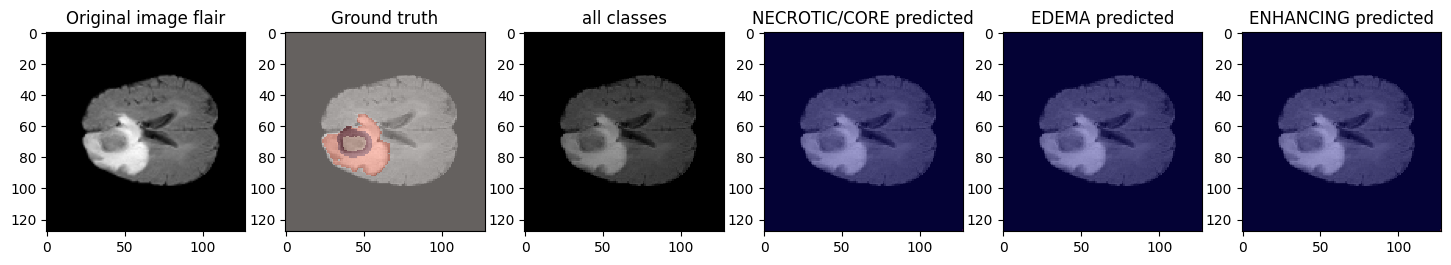

4/4 [==============================] - 0s 47ms/step


<Figure size 1800x5000 with 0 Axes>

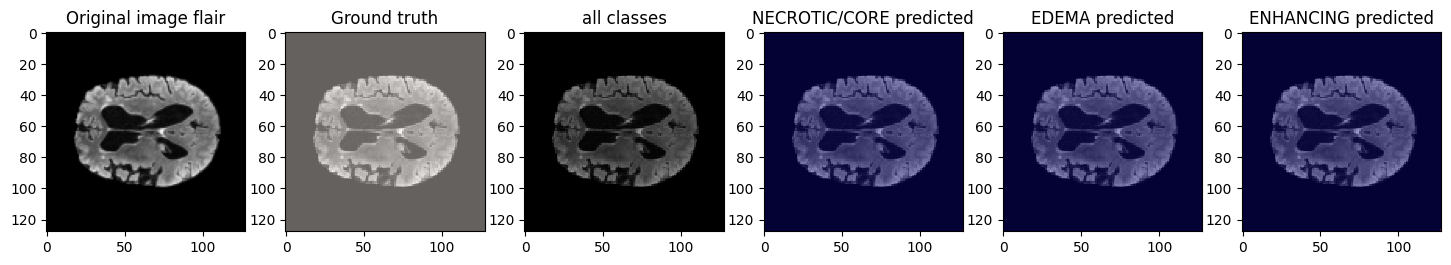

4/4 [==============================] - 0s 31ms/step


<Figure size 1800x5000 with 0 Axes>

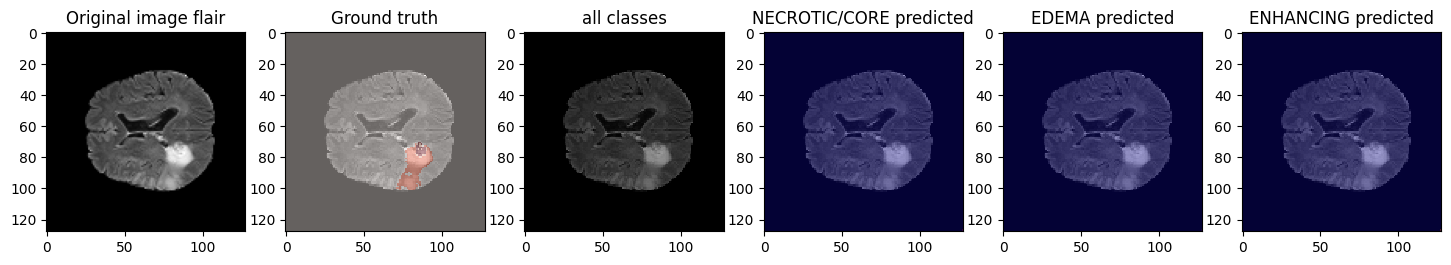

4/4 [==============================] - 0s 29ms/step


<Figure size 1800x5000 with 0 Axes>

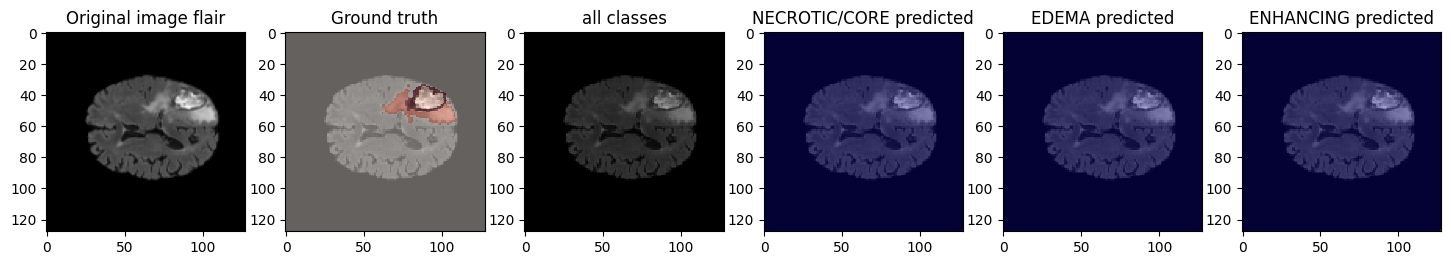

4/4 [==============================] - 0s 40ms/step


<Figure size 1800x5000 with 0 Axes>

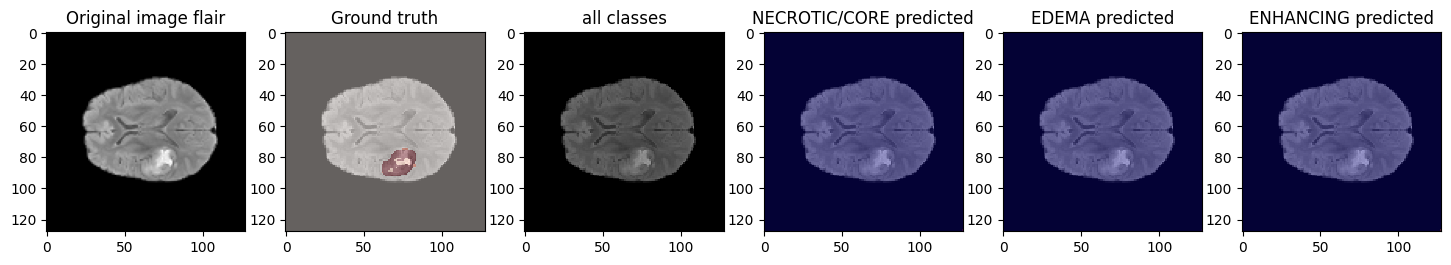

4/4 [==============================] - 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

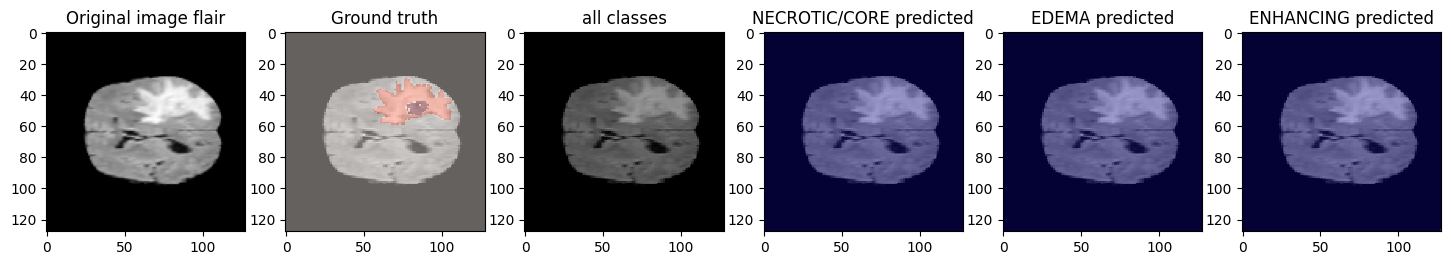

4/4 [==============================] - 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

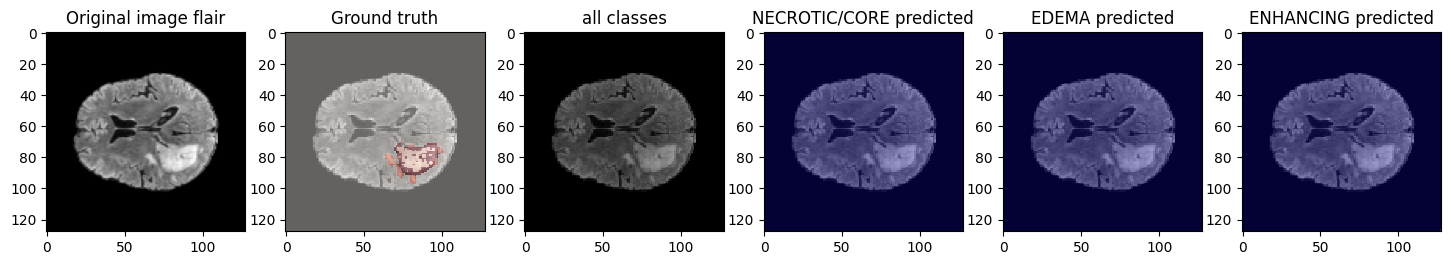

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

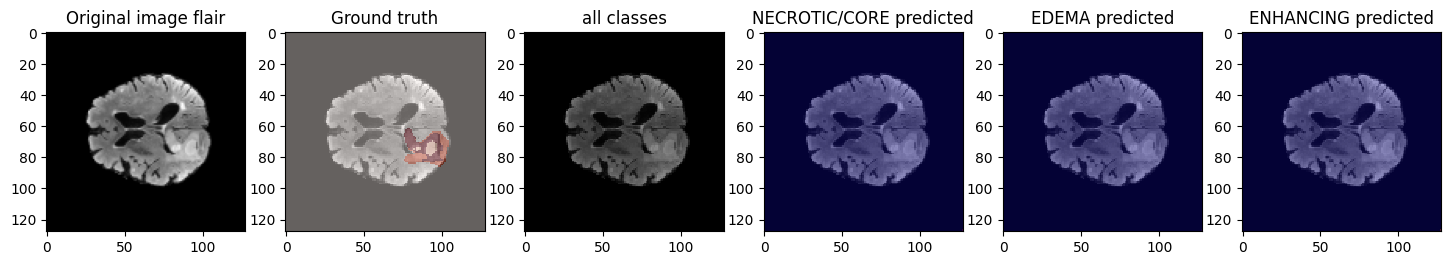

4/4 [==============================] - 0s 32ms/step


<Figure size 1800x5000 with 0 Axes>

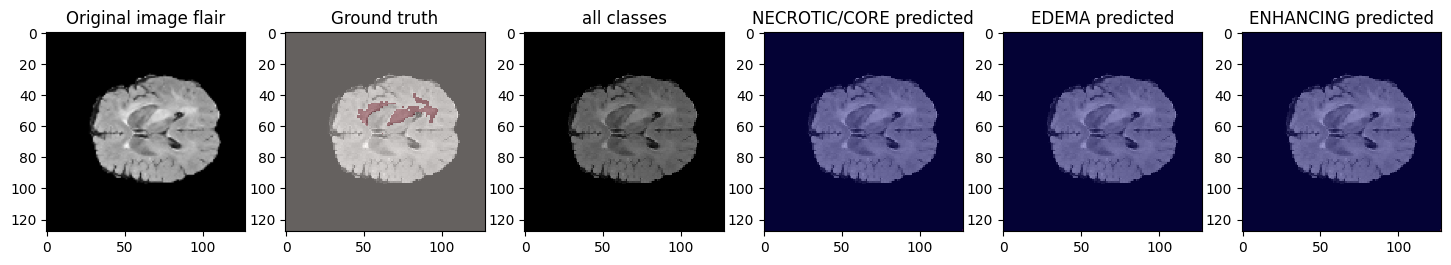

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

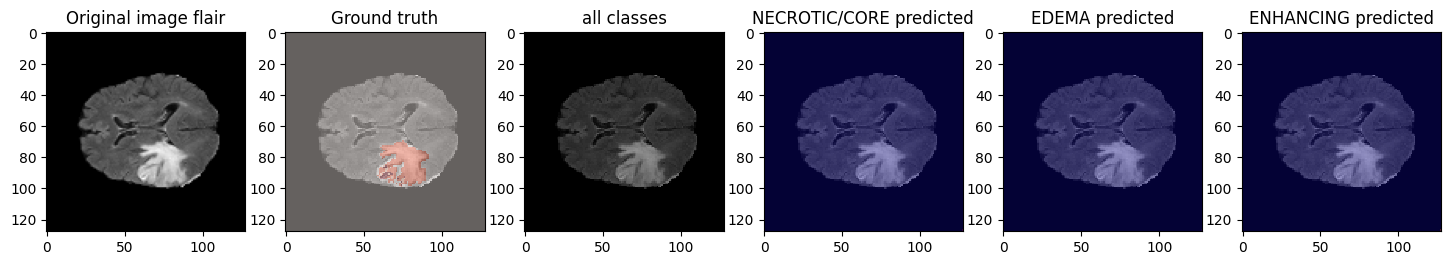

4/4 [==============================] - 0s 37ms/step


<Figure size 1800x5000 with 0 Axes>

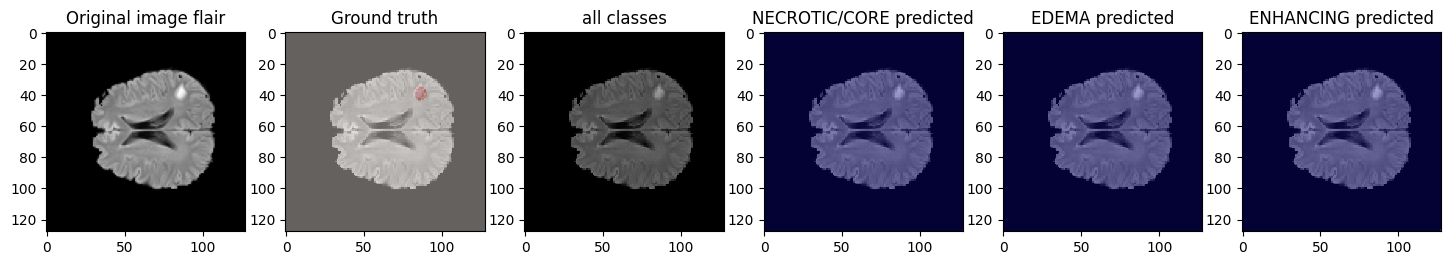

4/4 [==============================] - 0s 29ms/step


<Figure size 1800x5000 with 0 Axes>

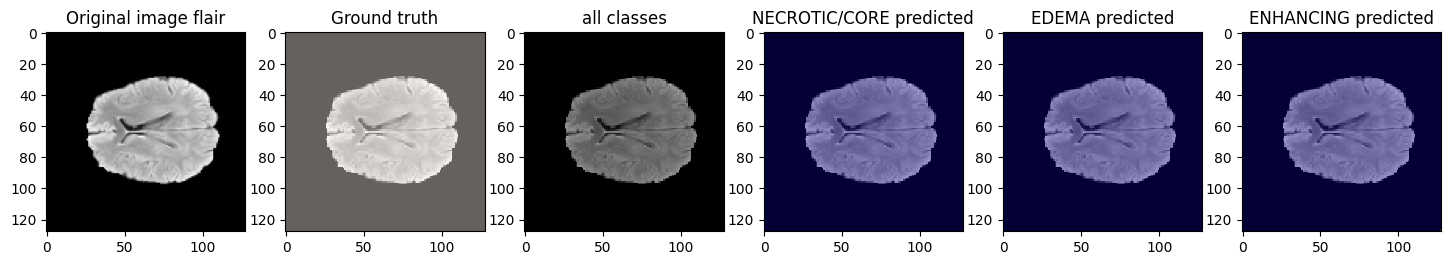

CPU times: user 58.8 s, sys: 5.81 s, total: 1min 4s
Wall time: 59 s


In [31]:
%%time
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

   # /content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii

    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    vol_path = case_path + case + '_flair.nii.gz';
    flair=nib.load(vol_path).get_fdata()
    
    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    vol_path = case_path + case + '_t1ce.nii.gz';
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = TRAIN_DATASET_PATH + case + '/'

    # TRAIN_DATASET_PATH + test_ids[0] + "/" + test_ids[0] + '_flair.nii'

    gt = nib.load(path + case +'_seg.nii.gz').get_fdata()
    origImage = nib.load(path + case +'_flair.nii.gz').get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='nearest', alpha=0.4) 
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Blues", interpolation='nearest', alpha=0.4)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="plasma", interpolation='nearest', alpha=0.4)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="plasma", interpolation='nearest', alpha=0.4)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="plasma", interpolation='nearest', alpha=0.4)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()
    
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])
showPredictsById(case=test_ids[7])
showPredictsById(case=test_ids[8])
showPredictsById(case=test_ids[9])
showPredictsById(case=test_ids[10])
showPredictsById(case=test_ids[11])
showPredictsById(case=test_ids[12])
showPredictsById(case=test_ids[13])
showPredictsById(case=test_ids[14])
showPredictsById(case=test_ids[15])
showPredictsById(case=test_ids[16])
showPredictsById(case=test_ids[17])
showPredictsById(case=test_ids[18])
showPredictsById(case=test_ids[19])
showPredictsById(case=test_ids[20])

4/4 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

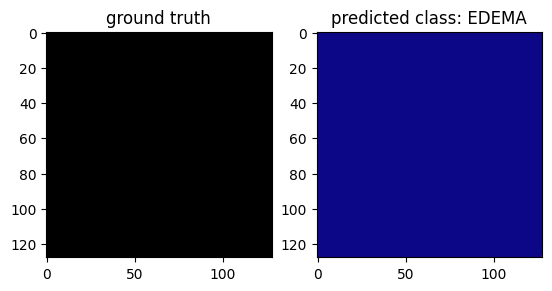

CPU times: user 1.22 s, sys: 303 ms, total: 1.52 s
Wall time: 1.34 s


In [32]:
%%time
case = test_ids[22]
# path = f"../input/brats2018-dataset/MICCAI_BraTS_2018_Data_Training/Brats18_{case}"
path = TRAIN_DATASET_PATH + case + "/" 
#gt = nib.load(path + test_ids[4] +'_seg.nii').get_fdata()
gt = nib.load(path + case +'_seg.nii.gz').get_fdata()
p = predictByPath(path,case)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]
i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')

axarr[1].imshow(p[i,:,:,eval_class], cmap="plasma")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()